In [1]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ================================

<img src="https://developer.download.nvidia.com/notebooks/dlsw-notebooks/merlin_models_03-exploring-different-models/nvidia_logo.png" style="width: 90px; float: right;">

# Iterating over Deep Learning Models using Merlin Models

This notebook is created using the latest stable [merlin-tensorflow](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/merlin/containers/merlin-tensorflow/tags) container. 

In this example, we'll demonstrate how to build and train several popular deep learning-based ranking model architectures. Merlin Models provides a high-level API to define those architectures, but allows for customization  as they are composed by reusable building blocks.

In this example notebook, we use for training and evaluation synthetic data that mimics the schema (features and cardinalities) of [Ali-CCP dataset](https://tianchi.aliyun.com/dataset/dataDetail?dataId=408#1): Alibaba Click and Conversion Prediction dataset. The Ali-CCP is a dataset gathered from real-world traffic logs of the recommender system in Taobao, the largest online retail platform in the world. To download the raw Ali-CCP training and test datasets visit [tianchi.aliyun.com](https://tianchi.aliyun.com/dataset/dataDetail?dataId=408#1). You can get the raw dataset via this [get_aliccp() function](https://github.com/NVIDIA-Merlin/models/blob/main/merlin/datasets/ecommerce/aliccp/dataset.py#L43) and generate the parquet files from it to be used in this example.

### Learning objectives
- Preparing the data with NVTabular
- Training different deep learning-based ranking models with Merlin Models

## Importing Libraries

Let's start with importing the libraries that we'll use in this notebook.

In [2]:
import os
import numpy as np

from nvtabular.loader.tf_utils import configure_tensorflow

configure_tensorflow()

import nvtabular as nvt
from nvtabular.ops import *
from merlin.models.utils.example_utils import workflow_fit_transform, save_results

from merlin.schema.tags import Tags

import merlin.models.tf as mm
from merlin.io.dataset import Dataset

import tensorflow as tf

2022-10-19 17:09:23.159971: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-19 17:09:24.697224: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-10-19 17:09:24.697249: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-10-19 17:09:24.915070: I tensorflow/core/platform/cpu_feature_guard.cc:193] This Tens

## Feature Engineering with NVTabular

When we work on a new recommender systems, we explore the dataset, first. In doing so, we define our input and output paths. We will use the parquet files in the test folder to validate our trained model.

In [3]:
from merlin.datasets.synthetic import generate_data

DATA_FOLDER = os.environ.get("DATA_FOLDER", "/workspace/data/")

NUM_ROWS = os.environ.get("NUM_ROWS", 1000000)
SYNTHETIC_DATA = eval(os.environ.get("SYNTHETIC_DATA", "True"))

if SYNTHETIC_DATA:
    train, valid = generate_data("aliccp-raw", int(NUM_ROWS), set_sizes=(0.7, 0.3))
    # save the datasets as parquet files
    train.to_ddf().to_parquet(os.path.join(DATA_FOLDER, "train"))
    valid.to_ddf().to_parquet(os.path.join(DATA_FOLDER, "valid"))

/home/alaiacano/.pyenv/versions/3.8.10/envs/merlin38/lib/python3.8/site-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
/home/alaiacano/.pyenv/versions/3.8.10/envs/merlin38/lib/python3.8/site-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/home/alaiacano/.pyenv/versions/3.8.10/envs/merlin38/lib/python3.8/site-packages/merlin/io/dataset.py:251: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [4]:
train_path = os.path.join(DATA_FOLDER, "train", "*.parquet")
valid_path = os.path.join(DATA_FOLDER, "valid", "*.parquet")
output_path = os.path.join(DATA_FOLDER, "processed")

Our dataset has only categorical features. Below, we create continuous features using target encoding (TE) technique. Target Encoding calculates the statistics from a target variable grouped by the unique values of one or more categorical features. For example, in a binary classification problem, TE calculates the conditional probability that the target is true for each category value- a simple mean. To learn more about TE, visit this [medium blog](https://medium.com/rapids-ai/target-encoding-with-rapids-cuml-do-more-with-your-categorical-data-8c762c79e784).

Note that the `Ali-CCP` dataset has `click` and `conversion` target columns (which could be used for Multi-Task Learning) but we only focus on building different ranking models with binary target column `click`.

We use a utility function, `workflow_fit_transform` perform to fit and transform steps on the raw dataset applying the operators defined in the NVTabular workflow pipeline below, and also save our workflow model. After fit and transform, the processed parquet files are saved to `output_path`.

In [5]:
%%time
category_temp_directory = os.path.join(DATA_FOLDER, "categories")

user_id = ["user_id"] >> Categorify(freq_threshold=5, out_path=category_temp_directory) >> TagAsUserID()
item_id = ["item_id"] >> Categorify(freq_threshold=5, out_path=category_temp_directory) >> TagAsItemID()
add_feat = [
    "user_item_categories",
    "user_item_shops",
    "user_item_brands",
    "user_item_intentions",
    "item_category",
    "item_shop",
    "item_brand",
] >> Categorify(out_path=category_temp_directory)

te_feat = (
    ["user_id", "item_id"] + add_feat
    >> TargetEncoding(["click"], kfold=1, p_smooth=20, out_path=category_temp_directory)
    >> Normalize()
)

targets = ["click"] >> AddMetadata(tags=[Tags.BINARY_CLASSIFICATION, "target"])

outputs = user_id + item_id + targets + add_feat + te_feat

# Remove rows where item_id==0 and user_id==0
outputs = outputs >> Filter(f=lambda df: (df["item_id"] != 0) & (df["user_id"] != 0))

workflow_fit_transform(outputs, train_path, valid_path, output_path)

/home/alaiacano/.pyenv/versions/3.8.10/envs/merlin38/lib/python3.8/site-packages/merlin/io/dataset.py:251: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/home/alaiacano/.pyenv/versions/3.8.10/envs/merlin38/lib/python3.8/site-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
/home/alaiacano/.pyenv/versions/3.8.10/envs/merlin38/lib/python3.8/site-packages/merlin/schema/tags.py:148: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(


CPU times: user 16.1 s, sys: 2.63 s, total: 18.7 s
Wall time: 17.4 s


## Training Recommender Models

NVTabular exported the schema file of our processed dataset. The `schema.pbtxt` is a protobuf text file that contains features metadata, including statistics about features such as cardinality, min and max values and also tags based on their characteristics and dtypes (e.g., categorical, continuous, list, item_id). The metadata information is loaded from schema and their tags are used to automatically set the parameters of Merlin Models. In other words, Merlin Models relies on the schema object to automatically build all necessary input and output layers.

In [6]:
train = Dataset(os.path.join(output_path, "train", "*.parquet"), part_size="500MB")
valid = Dataset(os.path.join(output_path, "valid", "*.parquet"), part_size="500MB")

# define schema object
schema = train.schema

In [7]:
target_column = schema.select_by_tag(Tags.TARGET).column_names[0]
target_column

'click'

We can print out all the features that are included in the `schema.pbtxt` file.

In [8]:
schema.column_names

['user_id',
 'item_id',
 'click',
 'user_item_categories',
 'user_item_shops',
 'user_item_brands',
 'user_item_intentions',
 'item_category',
 'item_shop',
 'item_brand',
 'TE_user_item_categories_click',
 'TE_user_item_shops_click',
 'TE_user_item_brands_click',
 'TE_user_item_intentions_click',
 'TE_item_category_click',
 'TE_item_shop_click',
 'TE_item_brand_click',
 'TE_user_id_click',
 'TE_item_id_click']

### Initialize Dataloaders

We're ready to start training, for that, we create our dataset objects, and under the hood we use Merlin `Loader` class for reading chunks of parquet files. `Loader` asynchronously iterate through CSV or Parquet dataframes on GPU by leveraging an NVTabular `Dataset`. To read more about Merlin optimized dataloaders visit [here](https://github.com/NVIDIA-Merlin/models/blob/main/merlin/models/tf/dataset.py#L141).

### Configures training for all models

In [9]:
batch_size = 16 * 1024
LR = 0.03

### NCF Model

We will first build and train a Neural Collaborative Filtering (NCF) model. Neural Collaborative Filtering [(NCF)](https://arxiv.org/pdf/1708.05031.pdf) Model  architecture explores neural network architectures for collaborative filtering, in other words explores the use of deep neural networks for learning the interaction function from data.

NCF feed categorical features into embedding layer, concat the embedding outputs and add multiple hidden layers via its MLP layer tower as seen in the figure. GMF and MLP uses separate user and item embeddings, and then outputs of their interactions from GMF Layer and MLP Layer are concatenated and fed to the final NeuMF (Neural Matrix Factorisation) layer.

<img src="./images/ncf.png"  width="30%">

<a href="https://arxiv.org/pdf/1708.05031.pdf">Image Source: NCF paper</a>

With `schema` object we enable NCF model easily to recognize item_id and user_id columns (defined in the schema.pbtxt with corresponding tags). Input block of embedding layers will be generated using item_id and user_id as seen in the Figure.

In [10]:
model = mm.benchmark.NCFModel(
    schema,
    embedding_dim=64,
    mlp_block=mm.MLPBlock([128, 64]),
    prediction_tasks=mm.BinaryClassificationTask(target_column),
)

In [11]:
%%time
opt = tf.keras.optimizers.Adagrad(learning_rate=LR)
model.compile(optimizer=opt, run_eagerly=False, metrics=[tf.keras.metrics.AUC()])
model.fit(train, validation_data=valid, batch_size=batch_size)

43/43 [==============================] - 6s 53ms/step - loss: 0.6932 - auc: 0.4997 - regularization_loss: 0.0000e+00 - val_loss: 0.6932 - val_auc: 0.4983 - val_regularization_loss: 0.0000e+00
CPU times: user 17.5 s, sys: 1.91 s, total: 19.4 s
Wall time: 7.42 s


Let's save our accuracy results

In [12]:
results_path = os.path.join(DATA_FOLDER, "results.txt")
if os.path.isfile(results_path):
    os.remove(results_path)

In [13]:
save_results("NCF", model, results_path)

Let's check out the model evaluation scores

In [14]:
metrics_ncf = model.evaluate(valid, batch_size=1024, return_dict=True)
metrics_ncf

293/293 [==============================] - 3s 9ms/step - loss: 0.6932 - auc: 0.4983 - regularization_loss: 0.0000e+00


{'loss': 0.6932048201560974,
 'auc': 0.4983401298522949,
 'regularization_loss': 0.0}

### MLP Model

Now we will change our model to Multi-Layer Percepton (MLP) model. MLP models feed categorical features into embedding layer, concat the embedding outputs and add multiple hidden layers.

<img src="./images/mlp.png"  width="30%">

Steps:

- Change the model to MLP model
- Rerun the pipeline from there from model.fit

In [15]:
# uses default embedding_dim = 64
model = mm.Model.from_block(mm.MLPBlock([64, 32]),
    schema, prediction_tasks=mm.BinaryClassificationTask(target_column)
)

In [16]:
%%time

opt = tf.keras.optimizers.Adagrad(learning_rate=LR)
model.compile(optimizer=opt, run_eagerly=False, metrics=[tf.keras.metrics.AUC()])
model.fit(train, validation_data=valid, batch_size=batch_size)

43/43 [==============================] - 4s 56ms/step - loss: 0.5932 - auc_1: 0.8512 - regularization_loss: 0.0000e+00 - val_loss: 0.7543 - val_auc_1: 0.5001 - val_regularization_loss: 0.0000e+00
CPU times: user 29.1 s, sys: 2.1 s, total: 31.2 s
Wall time: 5.21 s


In [17]:
save_results("MLP", model, results_path)

Let's check out the model evaluation scores

In [18]:
metrics_mlp = model.evaluate(valid, batch_size=1024, return_dict=True)
metrics_mlp

293/293 [==============================] - 3s 8ms/step - loss: 0.7543 - auc_1: 0.5001 - regularization_loss: 0.0000e+00


{'loss': 0.7542504072189331,
 'auc_1': 0.5001050233840942,
 'regularization_loss': 0.0}

### Wide&Deep model

The [Wide&Deep architecture](https://arxiv.org/abs/1606.07792) was proposed by Google in 2016 to balance between the ability of neural networks to generalize and capacity of linear models to memorize relevant feature interactions. The deep part is an MLP model, with categorical features represented as embeddings, which are concatenated with continuous features and fed through multiple MLP layers. The wide part is a linear model takes a sparse representation of categorical features (i.e. one-hot or multi-hot representation). Both wide and deep sub-models output a logit, which is summed and followed by sigmoid for binary classification loss.

<img src="./images/wide_and_deep.png"  width="30%">

#### Wide part

Typically we feed only categorical features to the wide part. So we filter only categorical features from the schema for the wide part. The categorical features are encoded with one_hot representation, like commonly done for linear models. 

In [19]:
cat_schema = schema.select_by_tag(Tags.CATEGORICAL)

one_hot_encoding = mm.CategoryEncoding(cat_schema, sparse=True, output_mode="one_hot") # One-hot encoding

Linear models are not able to compute feature interaction (like MLPs). So to give the wide part more power we perform feature interactions as a preprocessing step for wide part, so that every possible combination of the values of two categorical features is mapped to a single id. That way, the model is be able to pick paired feature relationships, e.g., a pattern between the a category of a product and the city of a user.   
Although, this approach leads to very high-cardinality resulting feature (product between the two features cardinalities). So typically we apply the *hashing trick* to limit the resulting cardinality. 
In below example you can see how easily can compute crossed features with Merlin Models. We use `max_level=2` here for paired feature interactions. Typically maximum `max_level=3` (3rd level), as the higher the level the greater the combinatorial explosion.

*Note*: some feature combinations might not add information to the model, for example, the feature cross between the item id and item category, as every item only maps to a single item category. You can explicitly ignore those combinations to reduce a bit the feature space.

In [20]:
features_crossing = mm.HashedCrossAll(
        cat_schema,
        num_bins=100, # The crossed features will be hashed to this number of bins
        max_level=2,
        output_mode="one_hot",
        sparse=True,
        ignore_combinations=[["item_id", "item_category"], 
                             ["item_id", "item_brand"]]
    )

You might have noticed that we set output of the one-hot and crossed features to be a sparse tensor (`sparse=True`), as only a few values are 1s and the large majority of values are 0s. This saves a lot of memory and also speeds up the computation of the wide part.  
*Note*: If you have categorical features which have multiple values (multi-hot) for the same data sample, you can set `output_mode="multi_hot"` for both `CategoryEncoding()` and `HashedCrossAll()`.

Below, we create a list with the preprocessing transformations for the wide part, where we concatenate all sparse outputs to be used by the linear model.

In [21]:
wide_preprocessing_blocks = mm.ParallelBlock([
                                              one_hot_encoding, 
                                              features_crossing
                                             ],
                                             aggregation="concat")

#### Deep part

The deep block is just an MLP model, which expects dense representation. 
The input continuous features are used as they are loaded, but categorical features need to be embedded. The embedding tables are created automatically based on the `deep_schema`, and optionally you can provide the `deep_input_block` for custom representation of input features.

In [22]:
deep_part = mm.MLPBlock([128, 64, 32])

#### Putting it all together

In [23]:
model = mm.WideAndDeepModel(
        schema,
        wide_schema=cat_schema,
        deep_schema=schema,
        wide_preprocess=wide_preprocessing_blocks,
        deep_block=deep_part,
        prediction_tasks=mm.BinaryClassificationTask(target_column),
    )

In [24]:
%%time
opt = tf.keras.optimizers.Adagrad(learning_rate=LR)
model.compile(optimizer=opt, run_eagerly=False, metrics=[tf.keras.metrics.AUC()])
model.fit(train, validation_data=valid, batch_size=batch_size)

/home/alaiacano/.pyenv/versions/3.8.10/envs/merlin38/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_2/parallel_block_6/sequential_block_16/sequential_block_15/private__dense_11/dense_11/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_2/parallel_block_6/sequential_block_16/sequential_block_15/private__dense_11/dense_11/embedding_lookup_sparse/Reshape:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/model_2/parallel_block_6/sequential_block_16/sequential_block_15/private__dense_11/dense_11/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


43/43 [==============================] - 34s 648ms/step - loss: 0.6748 - auc_2: 0.7995 - regularization_loss: 0.0000e+00 - val_loss: 0.6954 - val_auc_2: 0.5007 - val_regularization_loss: 0.0000e+00
CPU times: user 1min 53s, sys: 3.39 s, total: 1min 57s
Wall time: 36.1 s


*Note*: Here we use a single optimizer (Adagrad), but in the [Wide&Deep paper](https://arxiv.org/abs/1606.07792) the  authors describe to have used the Adagrad optimizer for the deep part and the FTRL optimizer for the wide part, which worked better with sparse inputs according to their experiments. With Merlin Models wou can use multiple optimizers for different sets of parameters, check the API documentation of `MultiOptimizer()` for more details.

In [25]:
save_results("Wide&Deep", model, results_path)

In [26]:
metrics_wide_n_deep = model.evaluate(valid, batch_size=1024, return_dict=True)
metrics_wide_n_deep

293/293 [==============================] - 14s 48ms/step - loss: 0.6954 - auc_2: 0.5007 - regularization_loss: 0.0000e+00


{'loss': 0.6954308152198792,
 'auc_2': 0.5006649494171143,
 'regularization_loss': 0.0}

### DLRM Model

Deep Learning Recommendation Model [(DLRM)](https://arxiv.org/abs/1906.00091) architecture is a popular neural network model originally proposed by Facebook in 2019 as a personalization deep learning model.

![DLRM](./images/DLRM.png)


DLRM accepts two types of features: categorical and numerical. 
- For each categorical feature, an embedding table is used to provide dense representation to each unique value. 
- For numerical features, they are fed to model as dense features, and then transformed by a simple neural network referred to as "bottom MLP". This part of the network consists of a series of linear layers with ReLU activations. 
- The output of the bottom MLP and the embedding vectors are then fed into the dot product interaction operation (see Pairwise interaction step). The output of "dot interaction" is then concatenated with the features resulting from the bottom MLP (we apply a skip-connection there) and fed into the "top MLP" which is also a series of dense layers with activations ((a fully connected NN). 
- The model outputs a single number (here we use sigmoid function to generate probabilities) which can be interpreted as a likelihood of a certain user clicking on an ad, watching a movie, or viewing a news page.


Steps:<br>
* Change the model to `DLRMModel`
* Rerun the pipeline from there from model.fit

In [27]:
model = mm.DLRMModel(
    schema,
    embedding_dim=64,
    bottom_block=mm.MLPBlock([128, 64]),
    top_block=mm.MLPBlock([128, 64, 32]),
    prediction_tasks=mm.BinaryClassificationTask(target_column),
)

In [28]:
%%time
opt = tf.keras.optimizers.Adagrad(learning_rate=LR)
model.compile(optimizer=opt, run_eagerly=False, metrics=[tf.keras.metrics.AUC()])
model.fit(train, validation_data=valid, batch_size=batch_size)

43/43 [==============================] - 6s 77ms/step - loss: 0.6557 - auc_3: 0.8000 - regularization_loss: 0.0000e+00 - val_loss: 0.7112 - val_auc_3: 0.4997 - val_regularization_loss: 0.0000e+00
CPU times: user 37.4 s, sys: 2.52 s, total: 39.9 s
Wall time: 6.71 s


In [29]:
save_results("DLRM", model, results_path)

Let's check out the model evaluation scores

In [30]:
metrics_dlrm = model.evaluate(valid, batch_size=1024, return_dict=True)
metrics_dlrm

293/293 [==============================] - 4s 11ms/step - loss: 0.7112 - auc_3: 0.4997 - regularization_loss: 0.0000e+00


{'loss': 0.7112371325492859,
 'auc_3': 0.49972301721572876,
 'regularization_loss': 0.0}

### DCN Model

DCN-V2 is an architecture proposed as an improvement upon the original [DCN model](https://arxiv.org/pdf/1708.05123.pdf). The explicit feature interactions of the inputs are learned through cross layers, and then combined with a deep network to learn complementary implicit interactions. The overall model architecture is depicted in Figure below, with two ways to combine the cross network with the deep network: (1) stacked and (2) parallel. The output of the embbedding layer is the concatenation of all the embedded vectors and the normalized dense features: x<sub>0</sub> = [x<sub>embed,1</sub>; . . . ; x<sub>embed,𝑛</sub>; 𝑥<sub>dense</sub>].

![DCN](./images/DCN.png)

<a href="https://arxiv.org/abs/2008.13535">Image Source: DCN V2 paper</a>

In this example, we build `DCN-v2 stacked` architecture. 

Steps:<br>
* Change the model to `DCNModel`
* Rerun the pipeline from there to model.fit

In [31]:
model = mm.DCNModel(
    schema,
    depth=2,
    deep_block=mm.MLPBlock([64, 32]),
    prediction_tasks=mm.BinaryClassificationTask(target_column),
)

In [32]:
%%time
opt = tf.keras.optimizers.Adagrad(learning_rate=LR)
model.compile(optimizer=opt, run_eagerly=False, metrics=[tf.keras.metrics.AUC()])
model.fit(train, validation_data=valid, batch_size=batch_size)

43/43 [==============================] - 5s 75ms/step - loss: 0.5500 - auc_4: 0.8734 - regularization_loss: 0.0000e+00 - val_loss: 0.8090 - val_auc_4: 0.5002 - val_regularization_loss: 0.0000e+00
CPU times: user 45.8 s, sys: 1.99 s, total: 47.8 s
Wall time: 6.3 s


In [33]:
save_results("DCN", model, results_path)

Let's check out the model evaluation scores

In [34]:
metrics_dcn = model.evaluate(valid, batch_size=1024, return_dict=True)
metrics_dcn

293/293 [==============================] - 3s 9ms/step - loss: 0.8090 - auc_4: 0.5002 - regularization_loss: 0.0000e+00


{'loss': 0.8090491890907288,
 'auc_4': 0.5001701712608337,
 'regularization_loss': 0.0}

Let's visualize our model validation accuracy values. Since we did not do any hyper-parameter optimization or extensive feature engineering here, we do not come up with a final conclusion that one model is superior to another.

You need to install matplotlib library before executing the following cell. You can install it by uncommenting the next cell.

In [ ]:
#!pip install matplotlib

In [35]:
import matplotlib.pyplot as plt


def create_bar_chart(text_file_name, models_name):
    """a func to plot barcharts via parsing the  accuracy results in a text file"""
    auc = []
    with open(text_file_name, "r") as infile:
        for line in infile:
            if "auc" in line:
                data = [line.rstrip().split(":")]
                key, value = zip(*data)
                auc.append(float(value[0]))

    X_axis = np.arange(len(models_name))

    plt.title("Models' accuracy metrics comparison", pad=20)
    plt.bar(X_axis - 0.2, auc, 0.4, label="AUC")

    plt.xticks(X_axis, models_name)
    plt.xlabel("Models")
    plt.ylabel("AUC")
    plt.show()

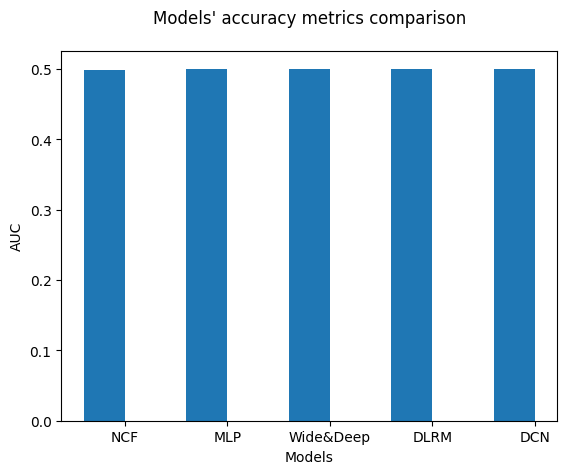

In [36]:
models_name = ["NCF", "MLP", "Wide&Deep", "DLRM", "DCN"]
create_bar_chart(results_path, models_name)

Let's remove the results file.

In [37]:
if os.path.isfile(results_path):
    os.remove(results_path)